In [41]:
import sys
sys.path.append('/home/azhuravl/work')

In [42]:
import stereoanyvideo.datasets.video_datasets as video_datasets

In [43]:
import importlib
importlib.reload(video_datasets)

<module 'stereoanyvideo.datasets.video_datasets' from '/home/azhuravl/work/stereoanyvideo/datasets/video_datasets.py'>

In [44]:
dataset_monkaa = video_datasets.SequenceSceneFlowDatasetCamera(
    aug_params=None,
    root="/home/azhuravl/scratch/SceneFlow",
    dstype="frames_cleanpass",
    sample_len=59,
    things_test=False,
    add_things=False,
    add_monkaa=False,
    add_driving=True,
    split="test",
    stride = 15,
)

Added 536 from Driving frames_cleanpass


In [45]:
len(dataset_monkaa)

536

In [46]:
dataset_monkaa[30]['metadata']

[[['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/left/0226.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/right/0226.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/left/0227.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/right/0227.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/left/0228.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/right/0228.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Driving/frames_cleanpass/15mm_focallength/scene_backwards/fast/left/02

In [47]:
data_0 = dataset_monkaa[0]
data_1 = dataset_monkaa[1]


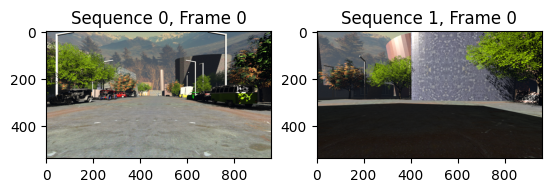

In [48]:
import matplotlib.pyplot as plt
# plot 0th frame of the first sequence and 2nd sequence
plt.subplot(1, 2, 1)
plt.imshow(data_0['img'][0][0].permute(1, 2, 0).int().numpy())
# plt.imshow(data_0['img'][0][0].permute(1, 2, 0).int().numpy())
plt.title('Sequence 0, Frame 0')
plt.subplot(1, 2, 2)
plt.imshow(data_1['img'][0][0].permute(1, 2, 0).int().numpy())
plt.title('Sequence 1, Frame 0')
plt.show()

In [9]:
dataset_monkaa[1]['metadata']

[[['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/left/0058.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/right/0058.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/left/0057.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/right/0057.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/left/0056.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/right/0056.png']],
 [['left',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/left/0055.png'],
  ['right',
   (540, 960),
   '/home/azhuravl/scratch/SceneFlow/Monkaa/frames_cleanpass/a_rain_of_stones_x2/right/0055.png'

In [11]:
data_0 = dataset_monkaa[0]

In [12]:
data_0.keys()

dict_keys(['viewpoint', 'metadata', 'depth2disp_scale', 'RTK', 'img', 'disp', 'valid_disp'])

In [13]:
import torch
from pytorch3d.utils.camera_conversions import opencv_from_cameras_projection

# If you have a PyTorch3D camera from your output_tensor
viewpoint = data_0["viewpoint"][0][0]  # First frame, left camera

# Convert to OpenCV format
# opencv_params = video_datasets.pytorch3d_to_opencv_camera_general(viewpoint, (540, 960))

R, t, K = opencv_from_cameras_projection(
    viewpoint,
    image_size=torch.tensor([[540, 960]])
)
R = R[0]
t = t[0]
K = K[0]

# Access the parameters
# K = opencv_params['K']          # 3x3 intrinsic matrix
# R = opencv_params['R']          # 3x3 rotation matrix
# t = opencv_params['t']          # 3x1 translation vector

In [14]:
# calculate depth from disparity using torch

import torch
disp = data_0['disp'][0][0]
focal_length = K[0, 0]
baseline = 1
depth = -(focal_length * baseline) / disp

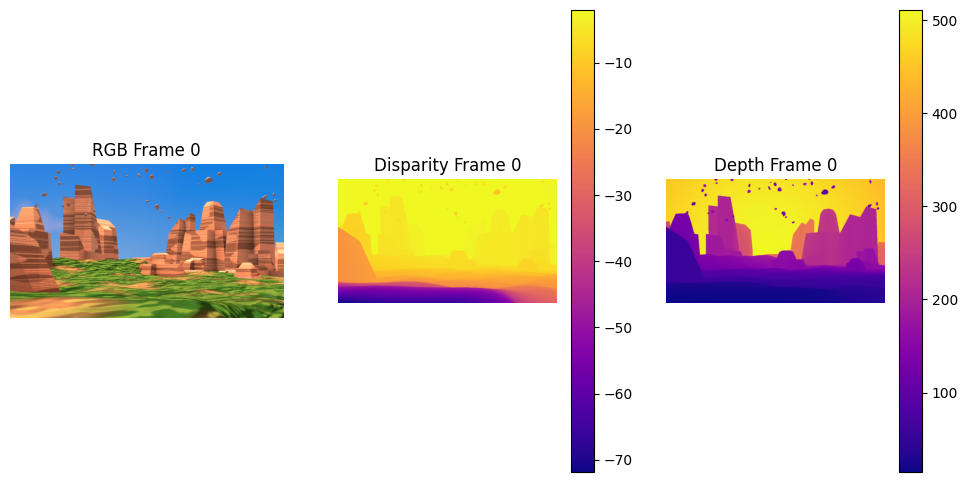

In [15]:
# plot rgb and disparity for the first frame
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(data_0['img'][0][0].permute(1, 2, 0).int().numpy())
plt.title('RGB Frame 0')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(data_0['disp'][0][0].permute(1, 2, 0).numpy(), cmap='plasma')
plt.title('Disparity Frame 0')
plt.axis('off')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(depth.permute(1, 2, 0).numpy(), cmap='plasma')
plt.title('Depth Frame 0')
plt.axis('off')
plt.colorbar()
plt.show()

In [16]:
import sys
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')

import warper_point_cloud

In [17]:
warper = warper_point_cloud.GlobalPointCloudWarper(device='cuda')

In [18]:
data_0['img'].shape

torch.Size([59, 2, 3, 540, 960])

In [51]:
from pytorch3d.renderer.camera_utils import join_cameras_as_batch

def extract_video_data_old(data, baseline=1):
    """
    Extract frames, depths, poses, and camera intrinsics from data object.
    
    Args:
        data: Data object containing 'img', 'disp', and 'viewpoint'
        baseline: Baseline for depth calculation (default: 1)
    
    Returns:
        frames_tensor: [T, 3, H, W] in [-1, 1] range
        depths: [T, 1, H, W] depth maps
        poses_tensor: [T, 4, 4] camera poses
        K_tensor: [T, 3, 3] camera intrinsics
    """
    # Convert to [-1, 1] range
    frames_tensor = data['img'][:,0] / 127.5 - 1.0  # [T, 3, H, W]
    disparity_tensor = data['disp'][:,0]  # [T, 1, H, W]
    
    image_size = torch.tensor([540, 960])
    
    poses_list = []
    K_list = []
    for i in range(frames_tensor.shape[0]):
        viewpoint = data["viewpoint"][i][0]
        # opencv_params = video_datasets.pytorch3d_to_opencv_camera_general(viewpoint, (540, 960))
                
        R = opencv_params['R']
        t = opencv_params['t']
        pose = torch.eye(4)
        pose[:3, :3] = R
        pose[:3, 3] = t.squeeze()
        poses_list.append(pose)
        
        K_list.append(opencv_params['K'])

    poses_tensor = torch.stack(poses_list)  # [T, 4, 4]
    K_tensor = torch.stack(K_list)  # [T, 3, 3]
    
    # Calculate focal length from K tensor
    focal_length = K_tensor[0, 0, 0]
    
    depths = -(focal_length * baseline) / disparity_tensor  # [T, 1, H, W]
    
    return frames_tensor, depths, poses_tensor, K_tensor





def extract_video_data(data, baseline=1):
    """
    Extract frames, depths, poses, and camera intrinsics from data object.
    
    Args:
        data: Data object containing 'img', 'disp', and 'viewpoint'
        baseline: Baseline for depth calculation (default: 1)
    
    Returns:
        frames_tensor: [T, 3, H, W] in [-1, 1] range
        depths: [T, 1, H, W] depth maps
        poses_tensor: [T, 4, 4] camera poses
        K_tensor: [T, 3, 3] camera intrinsics
    """
    # Convert to [-1, 1] range
    frames_tensor = data['img'][:,0] / 127.5 - 1.0  # [T, 3, H, W]
    disparity_tensor = data['disp'][:,0]  # [T, 1, H, W]
    
    image_size = torch.tensor([540, 960])
    
    # poses_list = []
    # K_list = []
    # for i in range(frames_tensor.shape[0]):
    #     viewpoint = data["viewpoint"][i][0]
    #     opencv_params = video_datasets.pytorch3d_to_opencv_camera_general(viewpoint, (540, 960))
                
    #     R = opencv_params['R']
    #     t = opencv_params['t']
    #     pose = torch.eye(4)
    #     pose[:3, :3] = R
    #     pose[:3, 3] = t.squeeze()
    #     poses_list.append(pose)
        
    #     K_list.append(opencv_params['K'])

    # poses_tensor = torch.stack(poses_list)  # [T, 4, 4]
    # K_tensor = torch.stack(K_list)  # [T, 3, 3]
    
    viewpoints_left = [data["viewpoint"][i][0] for i in range(frames_tensor.shape[0])]
    viewpoints_batch = join_cameras_as_batch(viewpoints_left)
    
    R, t, K = opencv_from_cameras_projection(
        viewpoints_batch,
        image_size=torch.tensor([[540, 960]]).repeat(frames_tensor.shape[0], 1)
    )
    poses_tensor = torch.eye(4).unsqueeze(0).repeat(frames_tensor.shape[0], 1, 1)  # [T, 4, 4]
    poses_tensor[:, :3, :3] = R
    poses_tensor[:, :3, 3] = t.squeeze(1)
    
    transform_mat = torch.tensor([
        [1, 0, 0, 0],
        [0, -1, 0, 0],
        [0, 0, -1, 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)
    poses_tensor = poses_tensor @ transform_mat
    # invert poses to get camera-to-world
    poses_tensor = torch.inverse(poses_tensor)
    
    # normalize the t
    
    
    K_tensor = K  # [T, 3, 3]
    
    
    # Calculate focal length from K tensor
    focal_length = K_tensor[0, 0, 0]
    
    depths = -(focal_length * baseline) / disparity_tensor  # [T, 1, H, W]
    
    return frames_tensor, depths, poses_tensor, K_tensor


In [20]:
data_0['viewpoint'][0]

[PerspectiveCameras(), PerspectiveCameras()]

In [52]:
import torch

frames_tensor, depths, poses_tensor, K_tensor = extract_video_data(data_0)

In [22]:
frames_tensor.shape

torch.Size([59, 3, 540, 960])

In [ ]:
from tqdm import tqdm

pc_list = []
color_list = []

with torch.no_grad():
    for j in tqdm(range(frames_tensor.shape[0])):
        i = 0
        points, colors, _ = warper.create_pointcloud_from_image(
            frames_tensor[i:i+1],
            None,
            depths[i:i+1],
            # torch.inverse(poses_tensor[i:i+1].to('cuda') @ transform_mat).to('cuda'),
            poses_tensor[i:i+1].to('cuda'),
            K_tensor[i:i+1],
            1,
        )
        pc_list.append(points)
        color_list.append(colors)

100%|██████████| 59/59 [00:00<00:00, 304.74it/s]


In [ ]:
import utils_autoregressive as utils_ar

warped_images = []
masks = []        

for i in tqdm(range(frames_tensor.shape[0])):

    warped_image, mask = warper.render_pointcloud_zbuffer_vectorized_point_size(
        pc_list[i],
        color_list[i],
        # torch.inverse(poses_tensor[i:i+1].to('cuda') @ transform_mat),
        poses_tensor[i:i+1].to('cuda'),
        K_tensor[i:i+1].to('cuda'),
        (540, 960),
        point_size=2,
    )
    
    cleaned_mask = utils_ar.clean_single_mask_simple(
        mask[0],
        kernel_size=9,
        n_erosion_steps=1,
        n_dilation_steps=1
        )
    # should stay in [-1, 1] range
    
    cleaned_mask = cleaned_mask.unsqueeze(0)
    warped_image = warped_image * cleaned_mask
    
    warped_images.append(warped_image)
    masks.append(cleaned_mask)


100%|██████████| 59/59 [00:00<00:00, 306.78it/s]


In [ ]:
from models.utils import save_video
import os


cond_video = (torch.cat(warped_images) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
save_video(
    cond_video.permute(0, 2, 3, 1),
    os.path.join('/home/azhuravl/work/TrajectoryCrafter/experiments/18-10-2025/monkaa_20251018_2224_90_0_0_0_1_auto_s4/stage_1/render_test.mp4'),
    fps=10,
)
# --- save inputs for visualization ---
save_video(
    (frames_tensor.permute(0, 2, 3, 1) + 1.0) / 2.0,
    '/home/azhuravl/work/TrajectoryCrafter/experiments/18-10-2025/monkaa_20251018_2224_90_0_0_0_1_auto_s4/stage_1/input_test.mp4',
    fps=10,
)

In [ ]:
poses_tensor

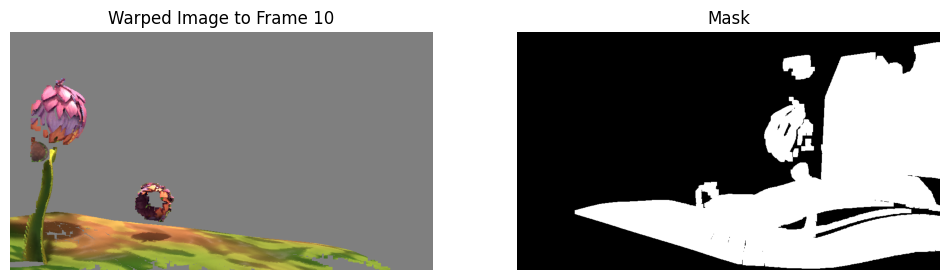

In [ ]:
import matplotlib.pyplot as plt

# plt.imshow(warped_image[0].cpu().permute(1, 2, 0).numpy())
# show image and mask
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(warped_images[40][0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title('Warped Image to Frame 10')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(masks[10][0].cpu().permute(1, 2, 0).numpy(), cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

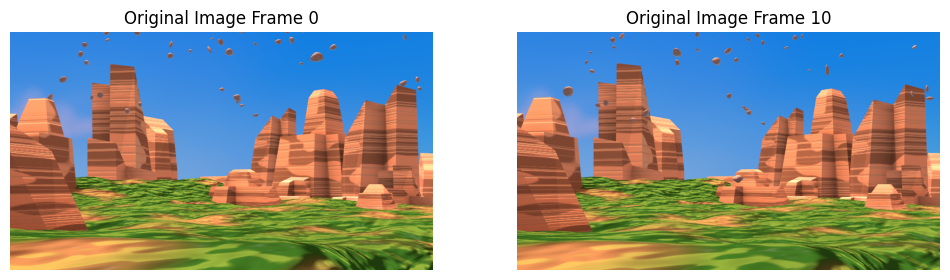

In [ ]:
# plot images 0 and 10
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(frames_tensor[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title('Original Image Frame 0')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(frames_tensor[10].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5)
plt.title('Original Image Frame 10')
plt.axis('off')
plt.show()

## Normal Warper, Double reprojection

In [23]:
import importlib
importlib.reload(utils)

NameError: name 'utils' is not defined

In [53]:
sys.path.append('/home/azhuravl/work/TrajectoryCrafter')

import models.utils as utils

warper_old = utils.Warper(device='cuda')

In [54]:
from tqdm import tqdm

warped_images = []
masks = []
warped_depths = []

for i in tqdm(range(10, frames_tensor.shape[0])):
    warped_frame2, mask2, warped_depth2, flow12 = warper_old.forward_warp(
        frame1=frames_tensor[i:i+1],
        mask1=None,
        depth1=depths[i:i+1],
        transformation1=poses_tensor[i:i+1],
        transformation2=poses_tensor[10:11],
        intrinsic1=K_tensor[i:i+1],
        intrinsic2=K_tensor[i:i+1],
        mask=False,
        twice=True,
    )
    # print(warped_frame2[0])
    warped_images.append(warped_frame2)
    masks.append(mask2)
    warped_depths.append(warped_depth2)
    
    # print(warped_frame2.shape, mask2.shape, warped_depth2.shape)

100%|██████████| 49/49 [00:12<00:00,  3.82it/s]


In [ ]:
warped_depths[j].shape

torch.Size([1, 1, 540, 960])

In [ ]:
torch.cat(warped_depths).shape

torch.Size([49, 1, 540, 960])

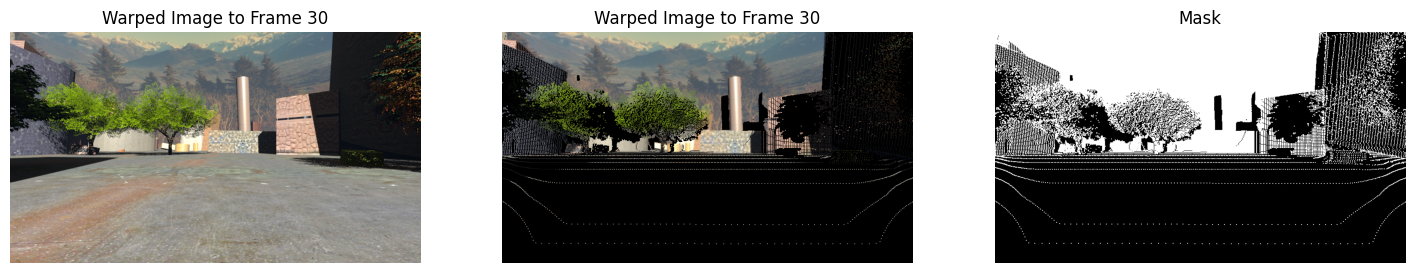

In [63]:
import numpy as np

# plot warped image j, mask j, warped depth j
j = 30

frame = frames_tensor[j+10].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
warped_image = warped_images[j][0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(frame)
plt.title('Warped Image to Frame {}'.format(j))
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(warped_image)
plt.title('Warped Image to Frame {}'.format(j))
plt.axis('off')

# plt.subplot(1,3,1)
# plt.imshow(depths[10+j].cpu().permute(1, 2, 0).numpy(), cmap='plasma')
# plt.title('Warped Image to Frame {}'.format(j))
# plt.axis('off')
# plt.colorbar()

# plt.subplot(1,3,2)
# plt.imshow((warped_depths[j][0].cpu().permute(1, 2, 0).numpy() + 1e-2), cmap='plasma')
# plt.title('Warped Image to Frame {}'.format(j))
# plt.axis('off')
# plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(masks[j][0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5, cmap='gray')
plt.title('Mask')
plt.axis('off')
plt.show()

In [28]:
warped_depths[0].shape

torch.Size([1, 1, 540, 960])

In [29]:
torch.cat(warped_depths).shape

torch.Size([49, 1, 540, 960])

In [30]:
from models.utils import save_video
import os


# cond_video = (torch.cat(warped_images) + 1.0) / 2.0  # [T, 3, H, W] in [0,1]
# save_video(
#     cond_video.permute(0, 2, 3, 1),
#     os.path.join('/home/azhuravl/work/TrajectoryCrafter/experiments/20-10-2025/render_test.mp4'),
#     fps=10,
# )
# # --- save inputs for visualization ---
# save_video(
#     (frames_tensor.permute(0, 2, 3, 1) + 1.0) / 2.0,
#     '/home/azhuravl/work/TrajectoryCrafter/experiments/20-10-2025/input_test.mp4',
#     fps=10,
# )
# save input and warped depths

warped_depths_tensor = torch.cat(warped_depths)
save_video(
    (warped_depths_tensor.permute(0, 2, 3, 1).repeat(1, 1, 1, 3)) / warped_depths_tensor.max() ,
    '/home/azhuravl/work/TrajectoryCrafter/experiments/20-10-2025/warped_depths_test.mp4',
    fps=10,
)
save_video(
    (depths.permute(0, 2, 3, 1).repeat(1, 1, 1, 3)) / depths.max() ,
    '/home/azhuravl/work/TrajectoryCrafter/experiments/20-10-2025/input_depths_test.mp4',
    fps=10,
)

## Run Diffusion

In [31]:
sys.path.append('/home/azhuravl/work/TrajectoryCrafter/notebooks/06_10_25_vggt')
from parsing import get_parser
import utils_autoregressive as utils_ar
from datetime import datetime
import os
import copy


sys.argv = [
    "",
    "--video_path", "/home/azhuravl/nobackup/DAVIS_testing/trainval/monkaa.mp4",
    "--n_splits", "4",
    "--overlap_frames", "0",
    "--radius", "0",
    "--mode", "gradual",
]

parser = get_parser()
opts_base = parser.parse_args()

timestamp = datetime.now().strftime("%Y%m%d_%H%M")
video_basename = os.path.splitext(os.path.basename(opts_base.video_path))[0]

# Setup
opts_base.weight_dtype = torch.bfloat16
opts_base.exp_name = f"{video_basename}_{timestamp}_autoregressive"
opts_base.save_dir = os.path.join(opts_base.out_dir, opts_base.exp_name)

# Create TrajCrafterVisualization instance for autoregressive generation
radius = opts_base.radius

variants = [
    ("right_90", [0, 90, radius, 0, 0]),
]

pose = [90, 0, 0, 0, 1]
name = f"{pose[0]}_{pose[1]}_{pose[2]}_{pose[3]}_{pose[4]}"

opts = copy.deepcopy(opts_base)
opts.exp_name = f"{video_basename}_{timestamp}_{name}_auto_s{opts_base.n_splits}"
opts.save_dir = os.path.join(opts.out_dir, opts.exp_name)
opts.camera = "target"
opts.target_pose = pose
opts.traj_txt = 'test/trajs/loop2.txt'

# Make directories
os.makedirs(opts.save_dir, exist_ok=True)

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_bwd")


In [ ]:
importlib.reload(utils_ar)

In [32]:
trajcrafter = utils_ar.TrajCrafterAutoregressive(opts)

Expected types for unet: ['UNetSpatioTemporalConditionModel'], got DiffusersUNetSpatioTemporalConditionModelDepthCrafter.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:186: FutureWarning: `get_3d_sincos_pos_embed` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:304: FutureWarning: `get_2d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type='pt' to use the new version now.
  deprecate("output_type=='np'", "0.33.0", deprecation_message, standard_warn=False)
/CT/video_4d_recon/nobackup/conda_envs/trajcrafter/lib/python3.10/site-packages/diffusers/models/embeddings.py:337: FutureWarning: `get_1d_sincos_pos_embed_from_grid` uses `torch` and supports `device`. `from_numpy` is no longer required.  Pass `output_type=

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [33]:
import numpy as np

# frames_tensor = (
    # torch.from_numpy(frames_np).permute(0, 3, 1, 2).to(opts.device) * 2.0 - 1.0
  # 49 576 1024 3 -> 49 3 576 1024, [-1,1]
# reverse this to get frames in numpy
frames_np = ((frames_tensor.cpu().permute(0, 2, 3, 1).numpy() + 1.0) / 2.0).astype(np.float32)

trajcrafter.prompt = trajcrafter.get_caption(opts, frames_np[opts.video_length // 2])
print(trajcrafter.prompt)

a 3d rendering of a rocky landscape with lots of rocks. The video is of high quality, and the view is very clear. High quality, masterpiece, best quality, highres, ultra-detailed, fantastic.


In [34]:
warped_images[0].shape

torch.Size([1, 3, 540, 960])

In [35]:
_, segment_dir = utils_ar.sample_diffusion(
    trajcrafter,
    frames_tensor[10:],
    warped_images,
    frames_tensor[:10],
    masks,
    opts,
)

Saving to: ./experiments/22-10-2025/monkaa_20251022_1014_90_0_0_0_1_auto_s4/stage_1


  0%|          | 0/50 [00:00<?, ?it/s]

/CT/video_4d_recon/work/TrajectoryCrafter/models/crosstransformer3d.py:793: FutureWarning: Accessing config attribute `num_layers` directly via 'CrossTransformer3DModel' object attribute is deprecated. Please access 'num_layers' over 'CrossTransformer3DModel's config object instead, e.g. 'unet.config.num_layers'.
  if hasattr(self, 'extracted_features') and i % (self.num_layers // 5) == 0 and i > 0: # [9, 18, 27, 36]:


In [36]:
collected_features = trajcrafter.pipeline.collected_features

In [37]:
collected_features.keys()

dict_keys(['timestep_839', 'timestep_679', 'timestep_519', 'timestep_359', 'timestep_199', 'timestep_39'])

In [38]:
for keys in collected_features['timestep_839'].keys():
    print(keys, '\t\t', collected_features['timestep_839'][keys].shape)

pos_embed 		 torch.Size([1, 13104, 3072])
cross_attn_0 		 torch.Size([1, 13104, 3072])
transformer_block_8 		 torch.Size([1, 13104, 3072])
transformer_block_8_text 		 torch.Size([1, 226, 3072])
cross_attn_1 		 torch.Size([1, 13104, 3072])
transformer_block_16 		 torch.Size([1, 13104, 3072])
transformer_block_16_text 		 torch.Size([1, 226, 3072])
transformer_block_24 		 torch.Size([1, 13104, 3072])
transformer_block_24_text 		 torch.Size([1, 226, 3072])
cross_attn_2 		 torch.Size([1, 13104, 3072])
transformer_block_32 		 torch.Size([1, 13104, 3072])
transformer_block_32_text 		 torch.Size([1, 226, 3072])
transformer_block_40 		 torch.Size([1, 13104, 3072])
transformer_block_40_text 		 torch.Size([1, 226, 3072])
final_norm 		 torch.Size([1, 13104, 3072])


In [39]:
# get size of collected features in MB
total_size = 0
for timestep in collected_features.keys():
    for keys in collected_features[timestep].keys():
        total_size += collected_features[timestep][keys].element_size() * collected_features[timestep][keys].nelement()
print(f"Total size of collected features: {total_size / (1024 ** 2):.2f} MB")        

Total size of collected features: 4646.60 MB


In [40]:
base_dir = '/home/azhuravl/scratch/linear_probing/features'

for timestep in collected_features.keys():
    for keys in collected_features[timestep].keys():
        feature_tensor = collected_features[timestep][keys]
        
        feature_dir = os.path.join(base_dir, timestep)
        os.makedirs(feature_dir, exist_ok=True)
        
        feature_path = os.path.join(feature_dir, f"{keys}.pt")
        torch.save(feature_tensor.cpu(), feature_path)

In [41]:
opts.sample_size

[384, 672]

In [42]:
# TODO
# +++ fix cameras - why it goes left-up?
# how to get GT depth: double-reprojection; Previous 10 frames as reference
# +++ why do we have so many features?

# +++ unpatchify and visualize features

# +++ set up double warping
# +++ how to make target trajectories? warp back to 1st pose

# +++ clean frames and depths
# +++ need filtering

# check filtering
# generate 250 features + depths samples


In [43]:
def reshape_patches_to_spatial_temporal(features, num_frames=13, patch_height=24, patch_width=42):
    """
    Convert flattened patch features back to spatial-temporal grid
    
    Args:
        features: [batch, 13104, feature_dim] or [13104, feature_dim]
        num_frames: 13
        patch_height: 24 (48 // patch_size)
        patch_width: 42 (84 // patch_size)
    
    Returns:
        reshaped_features: [batch, 13, 24, 42, feature_dim] or [13, 24, 42, feature_dim]
    """
    if features.dim() == 2:
        # [13104, feature_dim] → [13, 24, 42, feature_dim]
        return features.view(num_frames, patch_height, patch_width, -1)
    else:
        # [batch, 13104, feature_dim] → [batch, 13, 24, 42, feature_dim]
        batch_size = features.shape[0]
        feature_dim = features.shape[-1]
        return features.view(batch_size, num_frames, patch_height, patch_width, feature_dim)


In [56]:
feats_vis = reshape_patches_to_spatial_temporal(
    collected_features['timestep_519']['transformer_block_16']
)
feats_vis.shape

torch.Size([1, 13, 24, 42, 3072])

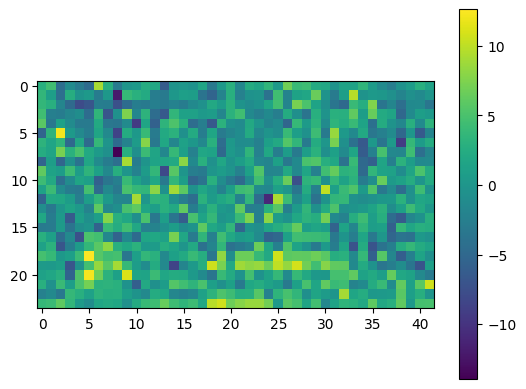

In [57]:
plt.imshow(feats_vis[0, 6, :, :, 20].cpu().float().numpy(), cmap='viridis')
plt.colorbar()

In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def analyze_transformer_pca(features, num_frames=13, patch_height=24, patch_width=42, 
                          frames_to_plot=None, components_to_plot=None, 
                          normalize_components=True, colormap='viridis'):
    """
    Minimalistic PCA analysis and visualization for transformer features
    
    Args:
        features: torch.Tensor of shape [1, 13104, 3072] or [13104, 3072]
        frames_to_plot: list of frame indices to plot, e.g. [0, 6, 12] or None for default
        components_to_plot: list of PCA component indices to plot, e.g. [0, 1] or [0, 4, 9] or None for default
        normalize_components: bool, whether to scale each component independently to [-1, 1]
        colormap: str, colormap to use for all components
    """
    # Convert to numpy and flatten
    if isinstance(features, torch.Tensor):
        features_np = features.detach().cpu().numpy()
    else:
        features_np = features
    
    if features_np.ndim == 3:
        features_flat = features_np.reshape(-1, features_np.shape[-1])  # [13104, 3072]
    else:
        features_flat = features_np
    
    # Determine number of components to compute
    if components_to_plot is None:
        n_components = 2  # Default
        components_to_plot = [0, 1]
    else:
        n_components = max(components_to_plot) + 1  # Compute enough components
    
    # Standardize and apply PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_flat)
    
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(features_scaled)  # [13104, n_components]
    
    # Reshape to spatial-temporal: [13, 24, 42, n_components]
    pca_spatial = pca_features.reshape(num_frames, patch_height, patch_width, n_components)
    
    # Normalize each component independently to [-1, 1]
    if normalize_components:
        pca_spatial_normalized = np.zeros_like(pca_spatial)
        for i in range(n_components):
            component_data = pca_spatial[:, :, :, i]
            comp_min, comp_max = component_data.min(), component_data.max()
            if comp_max > comp_min:  # Avoid division by zero
                # Scale to [-1, 1]
                pca_spatial_normalized[:, :, :, i] = 2 * (component_data - comp_min) / (comp_max - comp_min) - 1
            else:
                pca_spatial_normalized[:, :, :, i] = component_data
        pca_spatial_to_plot = pca_spatial_normalized
        vmin, vmax = -1, 1
    else:
        pca_spatial_to_plot = pca_spatial
        vmin, vmax = None, None
    
    # Select frames to plot
    if frames_to_plot is None:
        frames_to_plot = [0, num_frames//2, num_frames-1]  # Default: first, middle, last
    
    # Validate frame indices
    frames_to_plot = [f for f in frames_to_plot if 0 <= f < num_frames]
    n_frames_plot = len(frames_to_plot)
    n_components_plot = len(components_to_plot)
    
    # Create visualization
    fig, axes = plt.subplots(n_components_plot, n_frames_plot, 
                            figsize=(4*n_frames_plot, 3*n_components_plot))
    
    # Handle single component or single frame cases
    if n_components_plot == 1 and n_frames_plot == 1:
        axes = [[axes]]
    elif n_components_plot == 1:
        axes = [axes]
    elif n_frames_plot == 1:
        axes = [[ax] for ax in axes]
    
    for comp_idx, pc_idx in enumerate(components_to_plot):
        pc_data = pca_spatial_to_plot[:, :, :, pc_idx]
        
        for frame_idx_plot, frame_idx in enumerate(frames_to_plot):
            ax = axes[comp_idx][frame_idx_plot]
            im = ax.imshow(pc_data[frame_idx], cmap=colormap, aspect='auto',
                          vmin=vmin, vmax=vmax)
            ax.set_title(f'PC{pc_idx+1} F{frame_idx}\n({pca.explained_variance_ratio_[pc_idx]:.1%})')
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Add colorbar with proper range
            cbar = plt.colorbar(im, ax=ax, fraction=0.046)
            if normalize_components:
                cbar.set_label('Normalized [-1, 1]', fontsize=8)
    
    # Create title with component info
    component_info = [f'PC{i+1} ({pca.explained_variance_ratio_[i]:.1%})' 
                     for i in components_to_plot]
    total_variance = sum(pca.explained_variance_ratio_[i] for i in components_to_plot)
    
    norm_info = "Normalized [-1,1]" if normalize_components else "Raw values"
    plt.suptitle(f'PCA Analysis ({norm_info}): {", ".join(component_info)} | Total: {total_variance:.1%}')
    plt.tight_layout()
    plt.show()
    
    # Print detailed summary
    print("PCA Component Analysis:")
    for i in components_to_plot:
        print(f"  PC{i+1} explains {pca.explained_variance_ratio_[i]:.1%} of variance")
    print(f"Total variance (selected components): {total_variance:.1%}")
    print(f"Plotted frames: {frames_to_plot}")
    print(f"Plotted components: {[i+1 for i in components_to_plot]}")
    
    if normalize_components:
        print("Components normalized to [-1, 1] for better visualization")
        # Show original ranges for reference
        for i in components_to_plot:
            orig_data = pca_spatial[:, :, :, i]
            print(f"  PC{i+1} original range: [{orig_data.min():.3f}, {orig_data.max():.3f}]")
    
    return {
        'pca_spatial': pca_spatial,  # Original values
        'pca_spatial_normalized': pca_spatial_to_plot,  # Normalized values (if applied)
        'pca_model': pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'components_plotted': components_to_plot,
        'frames_plotted': frames_to_plot,
        'normalized': normalize_components
    }

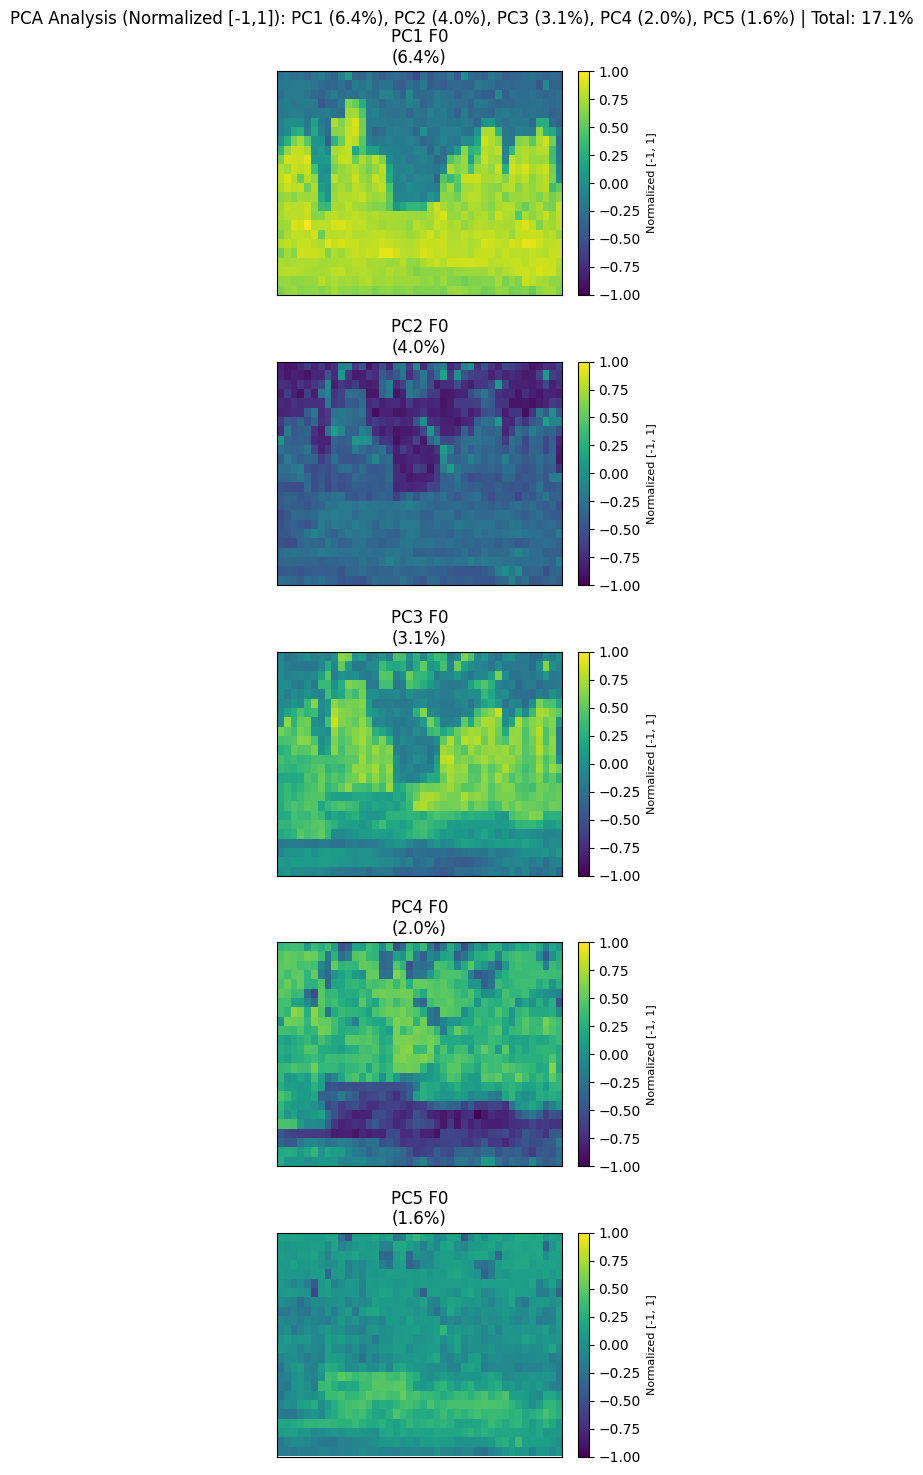

PCA Component Analysis:
  PC1 explains 6.4% of variance
  PC2 explains 4.0% of variance
  PC3 explains 3.1% of variance
  PC4 explains 2.0% of variance
  PC5 explains 1.6% of variance
Total variance (selected components): 17.1%
Plotted frames: [0]
Plotted components: [1, 2, 3, 4, 5]
Components normalized to [-1, 1] for better visualization
  PC1 original range: [-34.967, 22.415]
  PC2 original range: [-24.541, 35.703]
  PC3 original range: [-27.360, 20.450]
  PC4 original range: [-24.317, 17.925]
  PC5 original range: [-33.715, 31.507]


In [47]:
results = analyze_transformer_pca(
    collected_features['timestep_839']['transformer_block_16'].float(),
    frames_to_plot=[0],
    components_to_plot=[0, 1, 2, 3, 4],
    normalize_components=True,
    )

## Camera Motion Filtering

In [ ]:
# deg to rad
30 * np.pi / 180

0.5235987755982988

In [ ]:
# rad to deg
0.1 * 180 / np.pi

5.729577951308232

In [ ]:
import torch
from pathlib import Path
import json

class CameraMotionFilter:
    def __init__(self, device='cuda'):
        """
        Args:
            device: torch device to run computations on
        """
        self.min_total_translation = 10
        self.max_total_translation = 100
        
        self.min_total_rotation = 0.1
        self.max_total_rotation = 0.55  # ~30 degrees
        
        self.device = device
    
    def compute_motion_metrics(self, poses):
        """Compute motion metrics for a single video using PyTorch"""
        # Ensure tensor is on correct device
        if isinstance(poses, torch.Tensor):
            poses = poses.to(self.device)
        else:
            poses = torch.tensor(poses, dtype=torch.float32, device=self.device)
        
        if poses.shape[1:] == (4, 4):
            # Extract translations and rotations
            translations = poses[:, :3, 3]  # [n_frames, 3]
            rotations = poses[:, :3, :3]    # [n_frames, 3, 3]
        else:
            raise ValueError("Expected poses shape: (n_frames, 4, 4)")
        
        # Frame-to-frame translation distances
        trans_diffs = torch.diff(translations, dim=0)  # [n_frames-1, 3]
        trans_distances = torch.linalg.norm(trans_diffs, dim=1)  # [n_frames-1]
        
        # Frame-to-frame rotation angles (vectorized)
        rotations_curr = rotations[1:]  # [n_frames-1, 3, 3]
        rotations_prev = rotations[:-1] # [n_frames-1, 3, 3]
        
        # Relative rotations: R_rel = R_curr @ R_prev^T
        R_rel = torch.bmm(rotations_curr, rotations_prev.transpose(-1, -2))  # [n_frames-1, 3, 3]
        
        # Rotation angles from trace: angle = arccos((trace(R) - 1) / 2)
        traces = torch.diagonal(R_rel, dim1=-2, dim2=-1).sum(dim=-1)  # [n_frames-1]
        angles_arg = (traces - 1) / 2
        angles_arg = torch.clamp(angles_arg, -1.0, 1.0)  # Clamp for numerical stability
        rotation_angles = torch.acos(angles_arg)  # [n_frames-1]
        
        metrics = {
            'max_frame_translation': torch.max(trans_distances).item(),
            'mean_frame_translation': torch.mean(trans_distances).item(),
            'total_translation': torch.sum(trans_distances).item(),
            'max_frame_rotation': torch.max(rotation_angles).item(),
            'mean_frame_rotation': torch.mean(rotation_angles).item(),
            'total_rotation': torch.sum(rotation_angles).item(),
            'translation_std': torch.std(trans_distances).item(),
            'rotation_std': torch.std(rotation_angles).item()
        }
        
        return metrics
    
    def is_low_motion(self, poses):
        """Check if video meets motion criteria"""
        metrics = self.compute_motion_metrics(poses)
        
        # Check all criteria
        translation_ok = (metrics['total_translation'] <= self.max_total_translation)
        rotation_ok = (metrics['total_rotation'] <= self.max_total_rotation)
        
        non_zero = (metrics['total_translation'] >= self.min_total_translation) or \
                     (metrics['total_rotation'] >= self.min_total_rotation)
        
        criteria = [translation_ok, rotation_ok, non_zero]
        
        return all(criteria), metrics
    
    
# Usage examples:
filter_motion = CameraMotionFilter()

In [ ]:
filter_motion.is_low_motion(
    poses_tensor
)

(False,
 {'max_frame_translation': 0.8613817691802979,
  'mean_frame_translation': 0.3748965561389923,
  'total_translation': 21.743999481201172,
  'max_frame_rotation': 0.1031598299741745,
  'mean_frame_rotation': 0.08508540689945221,
  'total_rotation': 4.934953689575195,
  'translation_std': 0.24690358340740204,
  'rotation_std': 0.008936797268688679})